In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# 1. 处理成分数据

In [6]:
# def parse_elements(composition):
#     pattern = r"\(([A-Za-z\d.]+)\)([\d.]+)|([A-Z][a-z]*)([\d.]+)?"
#     matches = re.findall(pattern, composition)
#     elements = {}
#     for match in matches:
#         if match[0]:  # 如果有括号
#             sub_scale_factor = sum(float(x[1]) if x[1] else 1 for x in re.findall(r"([A-Z][a-z]*)([\d.]+)?", match[0]))
#             scale_factor = float(match[1]) / sub_scale_factor
#             sub_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", match[0])
#             for sub_match in sub_matches:
#                 if sub_match[0] not in elements:
#                     elements[sub_match[0]] = float(sub_match[1]) * scale_factor if sub_match[1] else scale_factor
#         elif match[2]:  # 如果没有括号
#             if match[2] not in elements:
#                 elements[match[2]] = float(match[3]) if match[3] else 1
#     sorted_elements = {key: value for key, value in sorted(elements.items(), key=lambda item: item[1], reverse=True)}
#     element_strings = [f"{element}{round(value,2)}" for element, value in sorted_elements.items()]
#     chem = "".join(element_strings)
#     return elements, chem

def parse_elements(composition):
    pattern = r"\[([A-Za-z\d.\(\)]+)]([\d.]+)|\(([A-Za-z\d.]+)\)([\d.]+)|([A-Z][a-z]*)([\d.]+)?"
    matches = re.findall(pattern, composition)
    elements = {}

    for match in matches:
        if match[0]:  # 如果有方括号
            bracket_scale_factor = float(match[1])
            bracket_content = match[0]
            bracket_matches = re.findall(pattern, bracket_content)

            for bracket_match in bracket_matches:
                if bracket_match[2]:  # 如果有括号
                    paren_scale_factor = float(bracket_match[3])
                    paren_content = bracket_match[2]
                    paren_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", paren_content)

                    for element, weight in paren_matches:
                        scaled_weight = float(weight) * paren_scale_factor * bracket_scale_factor if weight else paren_scale_factor * bracket_scale_factor

                        if element not in elements:
                            elements[element] = scaled_weight
                        else:
                            elements[element] += scaled_weight
                        
                elif bracket_match[4]:  # 如果没有括号
                    element, weight = bracket_match[4], bracket_match[5]
                    scaled_weight = float(weight) * bracket_scale_factor if weight else bracket_scale_factor

                    if element not in elements:
                        elements[element] = scaled_weight
                    else:
                        elements[element] += scaled_weight

        elif match[2]:  # 如果有括号，但没有方括号
            paren_scale_factor = float(match[3])
            paren_content = match[2]
            paren_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", paren_content)

            for element, weight in paren_matches:
                scaled_weight = float(weight) * paren_scale_factor if weight else paren_scale_factor

                if element not in elements:
                    elements[element] = scaled_weight
                else:
                    elements[element] += scaled_weight

        elif match[4]:  # 如果没有括号和方括号
            element, weight = match[4], match[5]
            scaled_weight = float(weight) if weight else 1

            if element not in elements:
                elements[element] = scaled_weight
            else:
                elements[element] += scaled_weight

    sorted_elements = {key: value for key, value in sorted(elements.items(), key=lambda item: item[1], reverse=True)}
    element_strings = [f"{element}{round(value,2)}" for element, value in sorted_elements.items()]
    chem = "".join(element_strings)
    return elements, chem


def check_sum(elements):
    total = sum(elements.values())
    return round(total, 2)

# 使用parse_elements和check_sum函数解析和检查成分
def parse_and_check(composition):
    elements, chem = parse_elements(composition)
    is_sum_100 = check_sum(elements)
    if abs(is_sum_100 - 100) > 0.5:
        print(f"Warning: {composition} is not normalized. Sum is {is_sum_100}")
    return elements, chem, abs(is_sum_100 - 100) < 0.5

In [8]:
parse_and_check("[(Fe0.9Co0.1)0.75B0.2Si0.05]96Nb4")

({'Fe': 64.80000000000001,
  'Co': 7.200000000000001,
  'B': 19.200000000000003,
  'Si': 4.800000000000001,
  'Nb': 4.0},
 'Fe64.8B19.2Co7.2Si4.8Nb4.0',
 True)

In [20]:
data_o = pd.read_excel("./Wang's Data/data_o.xlsx")
record_chem = {}
for index, row in data_o.iterrows():
    composition = row["Chemical compostion（at.%）"]
    if composition in record_chem:
        pass
        # print(record_chem[composition], index, composition)
    else:
        record_chem[composition] = index
    elements, chem, is_sum_100 = parse_and_check(composition)

    if not is_sum_100:
        print(f"index {index} sum {is_sum_100}:\n{row}\n")
    data_o.loc[index, "Chemical compostion"] = chem
    # 将新的成分列添加到DataFrame中
    for element, value in elements.items():
        if element not in data_o.columns:
            data_o[element] = 0
        data_o.loc[index, element] = value

In [31]:
data_o.replace("–", "", inplace=True)
data_o.drop_duplicates(subset='Chemical compostion', keep='first', inplace=True)
data_o.describe().to_excel("./Wang's Data/data_processed_describe.xlsx")

In [3]:
data_o = pd.read_excel("./Wang's Data/data_processed.xlsx")
data_o.describe().to_excel("./Wang's Data/data_processed_describe.xlsx")

# 2. 绘制数据分析图

In [25]:
# 设置箱线图样式
boxprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='--', linewidth=1.5, color='gray')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red', alpha=0.7)
medianprops = dict(linestyle='-', linewidth=2, color='blue')

def draw_box(data, target_name):
    plt.cla()
    data_d = [data]

    # 设置每组数据对应的标签
    labels = [target_name]

    # 绘制箱线图
    plt.boxplot(data_d, vert=False, showmeans=True, meanline=True,
                boxprops=boxprops, whiskerprops=whiskerprops, flierprops=flierprops, medianprops=medianprops, labels=labels)

    # 添加标题和标签
    plt.title(f'{target_name} Target Distributions(Filter)')
    plt.xlabel('Range')

    # 显示图形
    plt.savefig(f"./Wang's Data/{target_name}_box.png", dpi=300)

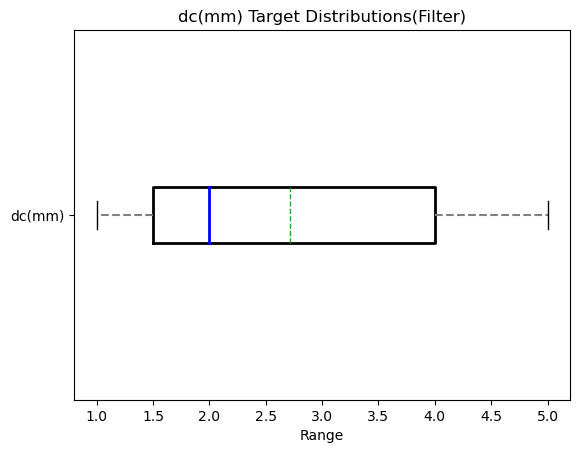

In [26]:
data = pd.read_excel("./Wang's Data/data_processed.xlsx")
target_names = ['E(GPa)', 'Tg(K)', 'Tm(K)', 'ry(GPa)', 'Tx(K)', 'Tl(K)', 'dc(mm)']
for target in target_names:
    non_empty_values = data.dropna(subset=[target])[target]
    draw_box(non_empty_values, target.replace('/', '_'))

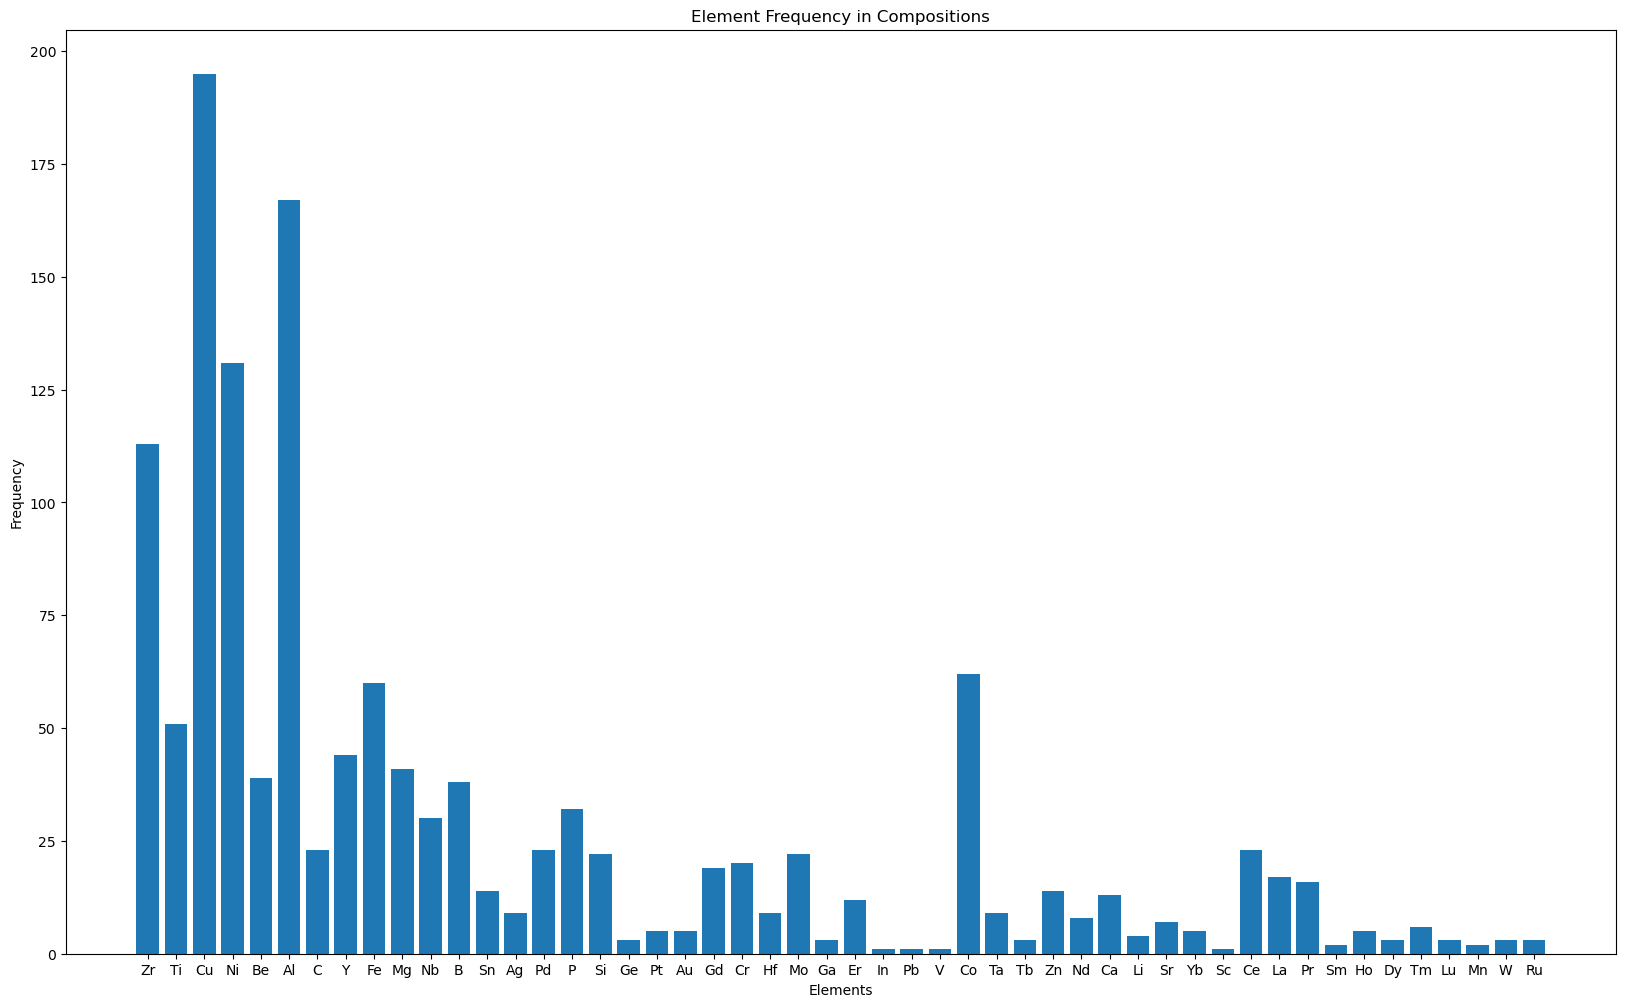

In [30]:
data_f = data.drop(target_names, axis=1, inplace=False)
data_f = data_f.drop(['Chemical compostion（at.%）', "Chemical compostion"], axis=1, inplace=False)
element_count = (data_f != 0).sum()
fig, ax = plt.subplots(figsize=(20, 12))
ax.bar(element_count.index, element_count.values)
ax.set_xlabel("Elements")
ax.set_ylabel("Frequency")
ax.set_title("Element Frequency in Compositions")
plt.savefig(f"./Wang's Data/element_statis.png", dpi=300)

In [28]:
properties = ['E(GPa)', 'Tg(K)', 'Tm(K)', 'ry(GPa)', 'Tx(K)', 'Tl(K)', 'dc(mm)']

for prop in properties:
    fig, ax = plt.subplots()
    non_empty_values = data.dropna(subset=[prop])[prop]
    ax.hist(non_empty_values, bins=10, alpha=0.7)
    ax.set_title(f"{prop} Distribution")
    ax.set_xlabel(prop)
    ax.set_ylabel("Frequency")
    prop = prop.replace('/', '_')
    # 保存每个子图为单独的图片
    plt.savefig(f"./Wang's Data/{prop}_distribution.png")
    plt.close(fig)